In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
nltk.download('vader_lexicon')
from datetime import datetime
import spacy as sp
nlps = sp.load('en')
from spacy.matcher import PhraseMatcher, Matcher
from collections import Counter, defaultdict

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/kaggle/input/reddit-rwallstreetbets/r_wallstreetbets_posts.csv


# Preprocessing

In [2]:
data = pd.read_csv('/kaggle/input/reddit-rwallstreetbets/r_wallstreetbets_posts.csv')
data.shape

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1118863, 12)

## Import tickers list

In [3]:
# load tickers
import requests # allows for file downloading
import os

filename = 'ticker.txt'
url = 'https://www.sec.gov/include/ticker.txt'
if os.path.exists(filename):
    print(f'{filename} already downloaded')
else:
    r = requests.get(url, allow_redirects=True)
    with open(filename, 'wb') as file:
        file.write(r.content)
    print(f'{filename} has been downloaded')



ticker.txt has been downloaded


In [4]:
# put tickers into dataframe
tickers = pd.read_csv('ticker.txt', delimiter = "\t", header=None)
tickers.columns = ['symbol', 'code']

In [5]:
# Note: some tickers are the same as common words or letters such as NAN, K, AND
tickers['symbol'] = tickers['symbol'].str.upper() 
print(tickers.iloc[4101])
# dropping 'NAN' North American Nickel ticker for now
tickers = tickers.dropna()
print(tickers.isnull().values.any())
tickers.head()

symbol       HUIZ
code      1778982
Name: 4101, dtype: object
False


,symbol,code
0,AAPL,320193
1,MSFT,789019
2,AMZN,1018724
3,GOOG,1652044
4,FB,1326801


## Drop columns

In [6]:
data = data.drop(columns = ['awarders', 'over_18', 'author_flair_text', 'removed_by'])

## Add date as column

In [7]:
data['date'] = pd.to_datetime(data['created_utc'], unit='s').dt.date

In [8]:
print(data.columns)
print(data.shape)

# analysis of date and scores
max_date, min_date = datetime.fromtimestamp(max(data.created_utc)), datetime.fromtimestamp(min(data.created_utc))
print('date ranges: ', min_date, max_date)
print('score range ', max(data.score), min(data.score))
print('num comments range ', max(data.num_comments), min(data.num_comments))

# find score and comments distributions
no_score_data = data[data.score==0]
low_score_data =data[data.score<= 100]
mid_score_data = data[(data.score <= 1000) & (data.score > 100)]
high_score_data = data[data.score > 1000]
print('scores: ', len(no_score_data), len(low_score_data), len(mid_score_data), len(high_score_data))
print('avg score: ', np.mean(data.score.values), 'std score: ', np.std(data.score.values))

Index(['id', 'title', 'score', 'author', 'total_awards_received',
       'created_utc', 'full_link', 'num_comments', 'date'],
      dtype='object')
(1118863, 9)
date ranges:  2012-04-11 16:40:40 2021-02-16 09:53:12
score range  134840 0
num comments range  204551 0
scores:  43920 1098686 17150 3027
avg score:  27.080198379962514 std score:  746.7225959766157


In [9]:
# keep posts with score > 100 or num comments > 100 or total awards > 10
# determine best threshold for keeping posts
df = data[(data.score >= 100) | (data.num_comments >= 50) | (data.total_awards_received >= 10)] 
print('comments avg and std: ', df.num_comments.mean(), df.num_comments.std())
print(df.shape)

comments avg and std:  496.93440145102784 3791.780930431707
(59544, 9)


In [10]:
df.head(5)

,id,title,score,author,total_awards_received,created_utc,full_link,num_comments,date
92,lkzviy,I am going to short the whole country of South...,1,The-Crazed-Crusader,0.0,1613465649,https://www.reddit.com/r/wallstreetbets/commen...,114,2021-02-16
185,lkyw58,I like the stonk,1,Allgoodnamesinuse,0.0,1613461282,https://www.reddit.com/r/wallstreetbets/commen...,50,2021-02-16
256,lky7u6,When you realize losing your hard earned money...,1,tkolu,0.0,1613458484,https://www.reddit.com/r/wallstreetbets/commen...,73,2021-02-16
261,lky552,Hiding shorts by ETF's?,1,--X0X0--,0.0,1613458201,https://www.reddit.com/r/wallstreetbets/commen...,139,2021-02-16
486,lkwazx,Dwight Schrute owns Palantir,1,OGSQ,0.0,1613451488,https://www.reddit.com/r/wallstreetbets/commen...,58,2021-02-16


# Vader Sentiment Scores

In [11]:
# Calculate polarity scores
sia = SIA()
# baseline compound is pos if >= 0.05, neg if <= -0.05 and neu else
# change baseline to 0 for binary classification
def calculate_sentiment(text):
    pol_score = sia.polarity_scores(text)
    if pol_score['compound'] >= 0.05:
        return 1
    elif pol_score['compound'] <= -0.05:
        return -1
    else:
        return 0

In [12]:
# add sentiment and compound col to df
df['sentiment'] = df.apply(lambda x: calculate_sentiment(x.title), axis=1)
df['compound'] = df.apply(lambda x: sia.polarity_scores(x.title)['compound'], axis=1)
df.head(3)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,title,score,author,total_awards_received,created_utc,full_link,num_comments,date,sentiment,compound
92,lkzviy,I am going to short the whole country of South...,1,The-Crazed-Crusader,0.0,1613465649,https://www.reddit.com/r/wallstreetbets/commen...,114,2021-02-16,0,0.0000
185,lkyw58,I like the stonk,1,Allgoodnamesinuse,0.0,1613461282,https://www.reddit.com/r/wallstreetbets/commen...,50,2021-02-16,1,0.3612
256,lky7u6,When you realize losing your hard earned money...,1,tkolu,0.0,1613458484,https://www.reddit.com/r/wallstreetbets/commen...,73,2021-02-16,-1,-0.4588


In [13]:
# counting sentiments 
sentiments = [-1, 0, 1]
sentiments_count = [sum(df.sentiment == -1), sum(df.sentiment == 0), sum(df.sentiment == 1)]
df.sentiment.value_counts()

 0    31448
 1    15434
-1    12662
Name: sentiment, dtype: int64

# TextBlob Sentiment Scores

In [14]:
# Calculating TextBlob Scores

from textblob import TextBlob

def calculate_sentiment_tb(text,compound=True):
    '''
    text: string input
    compound: if true, return compound score. Otherwise return -1, 0, or 1
    
    '''
    blob = TextBlob(text)
    
    if compound: 
        return blob.polarity
    
    else: 
        if blob.polarity >= 0.05:
            return 1
        elif blob.polarity <= -0.05:
            return -1
        else:
            return 0
        
df['tb_sentiment'] = df.apply(lambda x: calculate_sentiment_tb(x.title), axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
df.head(3)

,id,title,score,author,total_awards_received,created_utc,full_link,num_comments,date,sentiment,compound,tb_sentiment
92,lkzviy,I am going to short the whole country of South...,1,The-Crazed-Crusader,0.0,1613465649,https://www.reddit.com/r/wallstreetbets/commen...,114,2021-02-16,0,0.0000,0.100000
185,lkyw58,I like the stonk,1,Allgoodnamesinuse,0.0,1613461282,https://www.reddit.com/r/wallstreetbets/commen...,50,2021-02-16,1,0.3612,0.000000
256,lky7u6,When you realize losing your hard earned money...,1,tkolu,0.0,1613458484,https://www.reddit.com/r/wallstreetbets/commen...,73,2021-02-16,-1,-0.4588,-0.395833


# Finding stock tickers in posts

In [16]:
# stocks to find,
stocks = ['SPY', 'GME', 'AMC', 'TSLA', 'PLTR', 'APPL', 'AMD', 'BB', 'AMZN', 'NIO', 'NVDA', 'MU', 'RH', 'SNAP', 'NOK', 'SPCE']
company_names = {'S&P': 'SPY', 'GAMESTOP': 'GME', 'AMC': 'AMC', 'TESLA': 'TSLA', 'PALANTIR': 'PLTR', 'APPLE': 'APPL', 'AMD': 'AMD', 'BLACKBERRY': 'BB',
                 'AMAZON': 'AMZN', 'NIO': 'NIO', 'NVIDIA': 'NVDA', 'MICRON': 'MU', 'RESTORATION': 'RH', 'SNAPCHAT': 'SNAP', 'NOKIA': 'NOK', 'VIRGIN': "SPCE"}

In [17]:
print(list(company_names))

['S&P', 'GAMESTOP', 'AMC', 'TESLA', 'PALANTIR', 'APPLE', 'AMD', 'BLACKBERRY', 'AMAZON', 'NIO', 'NVIDIA', 'MICRON', 'RESTORATION', 'SNAPCHAT', 'NOKIA', 'VIRGIN']


In [18]:
# pattern matching with most frequent stocks 
nlp_freq = sp.blank('en')
matcher_freq = PhraseMatcher(nlp_freq.vocab, attr='TEXT')
freq_token_list = [nlp_freq(item) for item in stocks + list(company_names)]
matcher_freq.add('Freq Stocks', freq_token_list)

In [19]:
# find tickers and company names only from specified list
def find_tickers_and_names(title):
    '''
    Find all ticker and names of companies in the text specified in the company_names list
    and append all found tickers to a string 
    '''
    doc = nlp_freq(title.upper())
    matches = matcher_freq(doc)
    found_items = set([str(doc[match[1]: match[2]]).replace(' ', '') for match in matches])
    tickers_list = set()
    for item in found_items:
        if item in company_names:
            tickers_list.add(company_names[item])
        else:
            tickers_list.add(item)
    for ticker in tickers_list:
        ticker_freq[ticker] += 1
    return '_'.join(tickers_list)

In [20]:
# # pattern matching with imported tickers from sec
# nlp = sp.blank('en')
# matcher = PhraseMatcher(nlp.vocab, attr='TEXT')
# ticker_token_list = [nlp(item) for item in list(tickers.symbol)]
# # print(ticker_token_list)
# matcher.add('Ticker', ticker_token_list)

# # find all tickers mentioned in title of each post
# ticker_freq = Counter()
# def find_tickers(title):
#     doc = nlp(title)
#     matches = matcher(doc)
#     found_items = set([str(doc[match[1]: match[2]]).replace(' ', '') for match in matches])
#     tickers_list = set()
#     for item in found_items:
#         if item in company_names:
#             tickers_list.add(company_names[item])
#         else:
#             tickers_list.add(item)
#     for ticker in tickers_list:
#         ticker_freq[ticker] += 1
#     return '_'.join(tickers_list)

In [21]:
# add the column orgs to df which consists of a string of all tickers found in the post
ticker_freq = Counter()
df['orgs'] = df.apply(lambda x: find_tickers_and_names(x.title), axis=1)
print(ticker_freq, sum(ticker_freq.values()))

Counter({'GME': 3685, 'TSLA': 2085, 'SPY': 1044, 'AMD': 799, 'AMC': 780, 'PLTR': 683, 'MU': 617, 'BB': 569, 'AMZN': 548, 'SNAP': 406, 'APPL': 338, 'NIO': 309, 'NOK': 309, 'NVDA': 300, 'RH': 296, 'SPCE': 264}) 13032


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
# create new dataframe for only posts with specific organizations mentioned
df_stocks = df[df.orgs != '']
print(df_stocks.shape)
df_stocks.head(5)

(11924, 13)


,id,title,score,author,total_awards_received,created_utc,full_link,num_comments,date,sentiment,compound,tb_sentiment,orgs
486,lkwazx,Dwight Schrute owns Palantir,1,OGSQ,0.0,1613451488,https://www.reddit.com/r/wallstreetbets/commen...,58,2021-02-16,0,0.0000,0.000000,PLTR
526,lkw043,200K PLTR YOLO.,11,tqqq-ftw,0.0,1613450434,https://www.reddit.com/r/wallstreetbets/commen...,121,2021-02-16,1,0.2732,0.000000,PLTR
731,lkujx7,AMD strong upside for this week.,7,BeardlessPete,1.0,1613445651,https://www.reddit.com/r/wallstreetbets/commen...,60,2021-02-16,1,0.5106,0.433333,AMD
807,lktxjx,XRT is being used to hide GME shorts. XRT curr...,219,saliym1988,7.0,1613443702,https://www.reddit.com/r/wallstreetbets/commen...,434,2021-02-16,-1,-0.3147,0.000000,GME
884,lktele,GME Should Go Bankrupt,36,this_is_trash_really,2.0,1613441999,https://www.reddit.com/r/wallstreetbets/commen...,804,2021-02-16,-1,-0.5574,0.000000,GME


# Get posts by stock ticker

In [23]:
def get_sentiment_by_stock(dataframe, ticker, sentiment_type='compound'):
    '''
    get all the sentiment score assosicated with a stock
    
    ticker: string input
    sentiment_type: 'sentiment', 'compound',or 'tb_sentiment'
    
    '''
    cur_df = dataframe.copy()[dataframe.orgs.str.contains(ticker)]
    print('{} number of posts:'.format(ticker), cur_df.shape, 'unique dates:', np.unique(cur_df['date'], return_counts=True)[0].shape)
    # get average compound score for each date
    cur_df_scores = cur_df.groupby(cur_df['date'])[sentiment_type].mean()
    cur_df_scores = cur_df_scores.to_frame()
    cur_df_scores.reset_index(inplace=True)
    return cur_df_scores 

Sample for getting posts with GME mentioned

In [24]:
# Sample for getting posts with GME mentioned

# # Specify Stock of interest here
df_gme_scores = get_sentiment_by_stock(df_stocks, 'GME')
df_gme_scores.shape

GME number of posts: (3685, 13) unique dates: (192,)


(192, 2)

# Stock Data preprocessing for LSTM model 

In [25]:
!pip install yfinance
import yfinance as yf

  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=0cde76902daf77382b158cbd093b6535156f9572025a2d090721a8b597791ffc
  Stored in directory: /root/.cache/pip/wheels/26/af/8b/fac1b47dffef567f945641cdc9b67bb25fae5725d462a8cf81
  Created wheel for multitasking: filename=multitasking-0.0.9-py3-none-any.whl size=8368 sha256=4bbfbd66c7c3da07a1fc60f16f64af8641005b67bce5be4c040d67118302218c
  Stored in directory: /root/.cache/pip/wheels/ae/25/47/4d68431a7ec1b6c4b5233365934b74c1d4e665bf5f968d363a
Successfully built yfinance multitasking


In [26]:
def get_market_data(ticker, df_scores, min_date,drop_NaN=True, cols_to_drop=[]): 
    '''
    get the daily price of a stock with sentiment scores
    min_date: earilest date to get price. 'YYYY-MM-DD'
    
    fills in 'NaN' when market data not available (weekends & holidays) 
    
    '''
    ticker = yf.Ticker(ticker)
    min_date = pd.to_datetime(min_date).date()
    max_date = max(df_scores.date)
    # So the yfinance dataset doesn't have data for weekend and bank holidays, will make it NaN where the Date is applicable 
    hist = ticker.history(start=min_date, end=max_date)
    # get all scores with date greater than min_date   
    df_scores_date = df_scores[df_scores.date > min_date]
    # only drop NaN in date column and not in compound score
    if drop_NaN:
        # Drop samples with NAs i.e Bank holidays and weekend
        df_scores_date = df_scores_date.dropna(subset=['date'])
    df_scores_date.set_index('date', inplace=True, drop=True)
    #Combine the stock data with the sentiment Compound value
    df_wsb = pd.concat([hist, df_scores_date], axis=1)
    
    # drop specified columns from df
    df_wsb = df_wsb.drop(columns=cols_to_drop)
    
    print('Out of the total days represented in the df {}, only {} days have an existing coumpound score'.format(df_wsb.shape, df_scores.shape))
    return df_wsb

In [27]:
# Sample for geting the GME market df for lstm
df_gme_wsb = get_market_data('GME', df_gme_scores, '2019-01-01', drop_NaN=True)
df_gme_wsb.head(5)

Out of the total days represented in the df (589, 8), only (192, 2) days have an existing coumpound score


,Open,High,Low,Close,Volume,Dividends,Stock Splits,compound
2019-01-02,12.041450,12.747496,12.012435,12.641105,2124200.0,0.0,0.0,NaN
2019-01-03,12.554058,12.824870,12.273574,12.544387,1750400.0,0.0,0.0,NaN
2019-01-04,13.569602,14.788255,13.250431,14.739896,11915700.0,0.0,0.0,NaN
2019-01-07,14.614162,15.291192,14.449740,14.972020,4718000.0,0.0,0.0,NaN
2019-01-08,14.991364,15.368567,14.652849,15.291192,3443800.0,0.0,0.0,NaN


Show correlation of features

In [28]:
df_gme_wsb.corr()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,compound
Open,1.000000,0.971382,0.982749,0.980962,0.462783,-0.000561,NaN,-0.056139
High,0.971382,1.000000,0.928190,0.952947,0.514523,-0.001961,NaN,-0.063122
Low,0.982749,0.928190,1.000000,0.986853,0.493866,0.001679,NaN,-0.055291
Close,0.980962,0.952947,0.986853,1.000000,0.531151,-0.000447,NaN,-0.057013
Volume,0.462783,0.514523,0.493866,0.531151,1.000000,-0.014143,NaN,-0.034225
Dividends,-0.000561,-0.001961,0.001679,-0.000447,-0.014143,1.000000,NaN,NaN
Stock Splits,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
compound,-0.056139,-0.063122,-0.055291,-0.057013,-0.034225,NaN,NaN,1.000000


In [29]:
# Sample for geting SPY market and sentiment data in one line
# get spy market and sentiment data 
df_spy_wsb = get_market_data('SPY', get_sentiment_by_stock(df_stocks, 'SPY'),'2019-01-01', cols_to_drop=['Dividends', 'Stock Splits'], drop_NaN=True)
df_spy_wsb.head(5)
df_wsb = df_spy_wsb

SPY number of posts: (1044, 13) unique dates: (499,)
Out of the total days represented in the df (614, 6), only (499, 2) days have an existing coumpound score


# LSTM

## LSTM Data Preprocessing and train/test split

Concerns: The sentiment analysis includes weekend and bank holiday data wehn markets are closed. This implementation implements NaN in the stock data when such days occur. Currently I drop those rows as not to pull an error. Also if there were not posts on a specific date, then the sentiment becomes Nan. Therefore i replace the Nans in the 'compound' column with 0.

In [30]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

def get_scaled_X_y(dataset):
    '''
    apply preprocessing to dataset for lstm model
    returns X, y and the X, y minMax transformers for inverse transform 
    '''
    # Replace NA values in compound with 0 to represent neutral sentiment
    if 'compound' in dataset:
        dataset['compound'] = dataset['compound'].fillna(0)
    elif 'tb_sentiment' in dataset:
        dataset['tb_sentiment'] = dataset['tb_sentiment'].fillna(0)
        
    # # Drop samples with NAs i.e Bank holidays and weekend
    dataset = dataset.dropna()
    
    # Set the X and Y arrays from the dataframe
    # Change the Open value to the feature we want to predict
    y = dataset.Open.values.reshape(-1, 1)
    X = dataset.loc[:,dataset.columns!="Open"].values

    # Set MinMaxScaler
    X_MinMax = MinMaxScaler()
    X = X_MinMax.fit_transform(X)

    y_MinMax = MinMaxScaler()
    y = y_MinMax.fit_transform(y)
    return X, y, X_MinMax, y_MinMax

In [31]:
def lstm_train_test_split(X, y):
    '''
    apply time series train test split on lstm data
    return X_train, X_test, y_train, y_test
    '''
    #Initialize Time Series Split 
    tscv = TimeSeriesSplit()

    # If we want to do CV Time Series, we would run the model here in the for loop. It gives the time series split of train and test
    print(X.shape)
    for train_index, test_index in tscv.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

    # This reshapes the X datasets to LSTM format    
    X_train_scale = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test_scale = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    return X_train_scale, X_test_scale, y_train, y_test

## LSTM Model

In [32]:
# Create LSTM trained on sentiment analysis data
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam, SGD 
from sklearn.metrics import mean_squared_error

# Function calls and compiles the LSTM

def LSTM_Model(X_input_shape):
    
    model = Sequential()

    model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_input_shape, 1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))

    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [33]:
def train_lstm_model(X_train, y_train, X_test, y_test, y_MinMax, batch_size=16, epochs=100):
    model = LSTM_Model(X_train.shape[1])

    model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, verbose = 0)
    predicted_stock = model.predict(X_test)

    # For Regression
    testScore = np.sqrt(mean_squared_error(y_MinMax.inverse_transform(y_test)[:], y_MinMax.inverse_transform(predicted_stock)[:, 0]))
    print('test score:', testScore)

    #For Regression
    plt.plot(y_MinMax.inverse_transform(predicted_stock), label = 'Predicted')
    plt.plot(y_MinMax.inverse_transform(y_test), label = 'Actual')
    plt.legend()
    plt.xlabel('Number of days')
    plt.ylabel('Price in USD')
    plt.title('Predicted Stock Open vs Actual Stock Open'.format)
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()
    return predicted_stock 

## Regression to Classification LSTM


In [34]:
def get_prediction_acc(y_pred, y_test):
    # Convert the difference between the difference between current and previous day to a boolean and then into binary for price movement up or down metric.

    #target = 1 * ((df_wsb.Open.iloc[1:] - df_wsb.Open.iloc[:-1].values) > 0)

    y_test_bi = 1 * ((y_test[1:] - y_test[:-1]) > 0)

    # Do the same for the predicted regression above
    predicted_class = 1 * ((y_pred[1:] - y_pred[:-1]) > 0)


    # Find accuracy lol
    acc = (predicted_class == y_test_bi).mean()

    return acc

## Model Training

SPY number of posts: (1044, 13) unique dates: (499,)
Out of the total days represented in the df (614, 6), only (499, 2) days have an existing coumpound score
(526, 5)
test score: 3.440870624578819


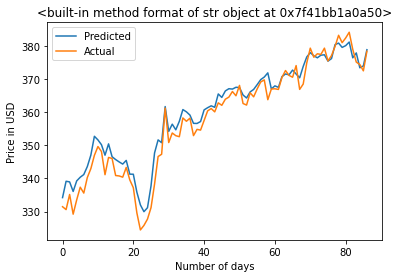

size of SPY test: (87, 1)
SPY acc: 0.7441860465116279
**************************************
GME number of posts: (3685, 13) unique dates: (192,)
Out of the total days represented in the df (589, 6), only (192, 2) days have an existing coumpound score
(534, 5)
test score: 44.617833496755374


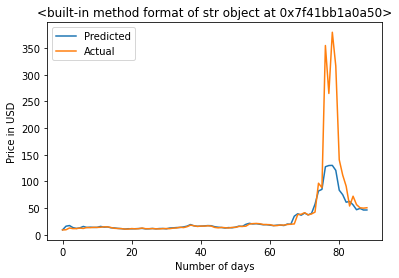

size of GME test: (89, 1)
GME acc: 0.6363636363636364
**************************************
TSLA number of posts: (2085, 13) unique dates: (787,)
Out of the total days represented in the df (677, 6), only (787, 2) days have an existing coumpound score
(534, 5)
test score: 69.8619236889638


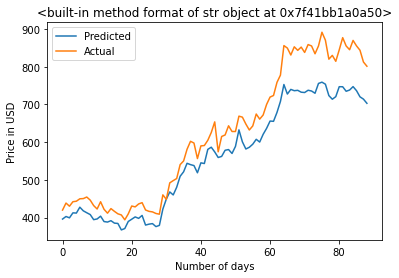

size of TSLA test: (89, 1)
TSLA acc: 0.7045454545454546
**************************************
AMD number of posts: (799, 13) unique dates: (453,)
Out of the total days represented in the df (587, 6), only (453, 2) days have an existing coumpound score
(534, 5)
test score: 2.1138528917796053


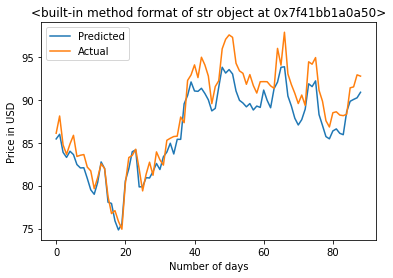

size of AMD test: (89, 1)
AMD acc: 0.7840909090909091
**************************************
PLTR number of posts: (683, 13) unique dates: (113,)
Out of the total days represented in the df (136, 6), only (113, 2) days have an existing coumpound score
(94, 5)
test score: 2.6879576242985057


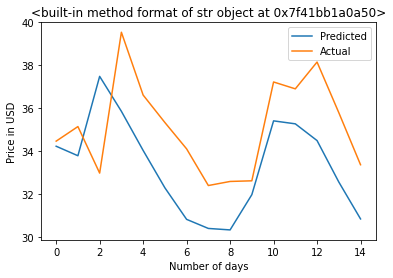

size of PLTR test: (15, 1)
PLTR acc: 0.6428571428571429
**************************************


In [35]:
stocks_to_test = ['SPY', 'GME', 'TSLA', 'AMD', 'PLTR']
training_params = {'SPY': {'batch_size': 16, 'epoch':30}, 'GME': {'batch_size': 16, 'epoch':30}, 'TSLA': {'batch_size': 16, 'epoch':30},
                   'AMD': {'batch_size': 16, 'epoch':30}, 'PLTR': {'batch_size': 16, 'epoch':30}}
for stock in stocks_to_test:
    stock_df = get_market_data(stock, get_sentiment_by_stock(df_stocks, stock),'2019-01-01', drop_NaN=True, cols_to_drop=['Dividends', 'Stock Splits'])
    X, y,_, y_MinMax = get_scaled_X_y(stock_df)
    X_train, X_test, y_train, y_test = lstm_train_test_split(X, y)
    predicted_stock = train_lstm_model(X_train, y_train, X_test, y_test, y_MinMax,
                                       batch_size=training_params[stock]['batch_size'], epochs=training_params[stock]['epoch'])
    print('size of {} test: {}'.format(stock, predicted_stock.shape))
    print('{} acc:'.format(stock), get_prediction_acc(predicted_stock, y_test))
    print('**************************************')

SPY number of posts: (1044, 13) unique dates: (499,)
Out of the total days represented in the df (614, 6), only (499, 2) days have an existing coumpound score
(526, 5)
test score: 8.062415551108138


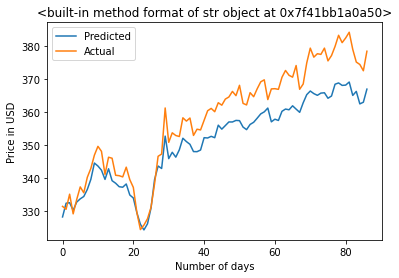

size of SPY test: (87, 1)
PLTR acc: 0.7441860465116279


In [36]:
# Example with Textblob sentiment on SPY
stock_df = get_market_data('SPY', get_sentiment_by_stock(df_stocks, 'SPY', sentiment_type='tb_sentiment'),'2019-01-01', drop_NaN=True, cols_to_drop=['Dividends', 'Stock Splits'])
X, y,_, y_MinMax = get_scaled_X_y(stock_df)
X_train, X_test, y_train, y_test = lstm_train_test_split(X, y)
predicted_stock = train_lstm_model(X_train, y_train, X_test, y_test, y_MinMax, batch_size=16, epochs=30)
print('size of {} test: {}'.format('SPY', predicted_stock.shape))
print('{} acc:'.format(stock), get_prediction_acc(predicted_stock, y_test))

# Hyper Parameter Tuning

In [37]:
# # Initialize data and stock to hyperparameter tune
# stock = 'AMD'
# stock_df = get_market_data(stock, get_sentiment_by_stock(df_stocks, stock),'2019-01-01', drop_NaN=True, cols_to_drop=['Dividends', 'Stock Splits'])
# X, y,_, y_MinMax = get_scaled_X_y(stock_df)
# X_train_scale, X_test_scale, y_train, y_test = lstm_train_test_split(X, y)

# # Set epoch range for hyperparameters
# epoch_range = range(1000)
    
# # Parameters for later
# opt_epoch = 0
# opt_batch = 0
# loss_diff = 100

# # Set batch sizes for hyperparameters
# batch = [16, 32, 64, 128, 256]

# # Iterate through batch_size
# for j in batch:
    
#     # Print Batch size to keep in the loop
#     print('Batch size: ' + str(j))
#     print('-------------------------------------------------------')
    
#     # Initialize train and test loss for ploting
#     train_loss = []
#     test_loss = []

#     # Initialize model
#     model = LSTM_Model(X_train_scale.shape[1])
    
#     #Iterate through epochs
#     for i in epoch_range:
        
#         # Print epochs every 100 to stay in the loop
#         if i % 100 == 0:
#             print('Epoch: ' +  str(i))
#             print('-------------------------------------------------------')

#         # Fit model on an epoch
#         model.fit(X_train_scale, y_train, epochs = 1, batch_size = j, verbose = 0)
        
#         # Predict on the train and test set 
#         predict_train = model.predict(X_train_scale)
#         predict_test = model.predict(X_test_scale)
        
#         # Obtain MSE fo train and test data
#         score_train = mean_squared_error(y_train[:], predict_train[:, 0])
#         score_test = mean_squared_error(y_test[:], predict_test[:, 0])
        
#         # Append value for this epoch to the list
#         train_loss.append(score_train)
#         test_loss.append(score_test)
        
#     # Plot train and test loss against the epoch range    
#     plt.plot(epoch_range, train_loss, label = 'train_loss')
#     plt.plot(epoch_range, test_loss, label = 'test_loss')
#     plt.legend()
#     plt.title('Batch Size: ' + str(j))
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.show()
    
#     # Obtain loss difference array 
#     loss = (abs(np.array(train_loss) - np.array(test_loss)))
    
#     # find minimum loss diff in array
#     min_loss = min(loss)
    
    
#     # if the minimum loss difference is smaller then the predefined one then replace the optimal epoch, batch size and diff_loss
#     if min_loss < loss_diff:
#         ind = np.where(loss == min_loss)
#         opt_epoch = epoch_range[ind[0][0]]
#         opt_batch = j
#         loss_diff = min_loss
#         print('Best epoch for this batch: ' + str(opt_epoch))
#         print('Minimum Loss for this batch: ' + str(loss_diff))

# print('-------------------------------------------------------')
# # Print out Optimal batch, epoch and the lowest loss difference for hyperparameters
# print('Optimal batch: ' + str(opt_batch))
# print('Optimal epoch: ' + str(opt_epoch))
# print('Lowest Loss dif of Train and Test: ' + str(loss_diff))